In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [14]:
data = pd.read_csv('../data/Churn_Modelling_Processed.csv')
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.327710,0,0,0.374258,2,-1.225291,1,1.0,1.0,0.022658,1
1,-0.441928,2,0,0.270773,1,0.117701,1,0.0,1.0,0.217345,0
2,-1.542575,0,0,0.374258,8,1.333219,3,1.0,0.0,0.241503,1
3,0.502968,0,0,0.063802,1,-1.225291,2,0.0,0.0,-0.108173,0
4,-0.057739,2,1,0.581229,8,0.597607,2,1.0,0.0,0.864593,1


In [15]:
X = data.drop(columns='Exited')
y = data['Exited']

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Crear y entrenar el modelo de Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = random_forest.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)

0.8667687595712098
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1567
           1       0.79      0.45      0.58       392

    accuracy                           0.87      1959
   macro avg       0.83      0.71      0.75      1959
weighted avg       0.86      0.87      0.85      1959



### **Resultados del modelo sin ajuste de hiperparámetros**

#### **Métricas clave:**
- **Precisión global (accuracy):** 86.68%
- **Clase 0 (No churn):**
  - Precisión: 88%
  - Recall: 97%
  - F1-Score: 92%
- **Clase 1 (Churn):**
  - Precisión: 79%
  - Recall: 45%
  - F1-Score: 58%
- **Promedios:**
  - Macro avg (sin ponderar): Recall: 71%, F1-Score: 75%
  - Weighted avg (ponderado): Recall: 87%, F1-Score: 85%

#### **Conclusión:**
Este modelo tiene un desempeño sólido con una alta precisión global (86.68%). Sin embargo, el recall para la clase 1 (clientes que churnean) es relativamente bajo (**45%**), lo que indica que el modelo no identifica correctamente una gran proporción de clientes que efectivamente churnean. Esto es común en problemas de datos desbalanceados, donde la clase mayoritaria domina las predicciones del modelo.

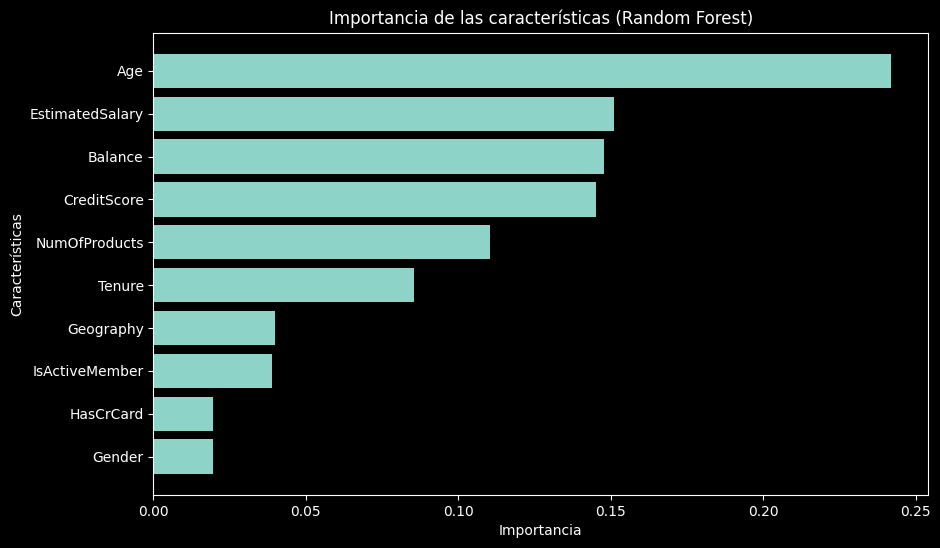

In [18]:
# Obtener las importancias de las características
feature_importances = random_forest.feature_importances_

# Asociar las importancias con los nombres de las columnas
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

### Eliminación de características menos importantes

Tras analizar la importancia de las características del modelo de Random Forest inicial, se identificó que las columnas `Gender` y `HasCrCard` tienen una contribución muy baja (<2%) en las predicciones. Estas características se eliminaron para reducir la complejidad del modelo y minimizar el ruido en los datos. 

**Razones para intentar esto:**
- **Reducción de complejidad**: Eliminar variables irrelevantes mejora la eficiencia computacional.
- **Ruido reducido**: Características con baja importancia pueden introducir ruido, afectando el rendimiento del modelo.
- **Simplificación**: Un modelo con menos características es más fácil de interpretar y mantener.

Tras eliminar estas columnas y volver a entrenar el modelo:
- La precisión global pasó de **86.68%** a **87.08%**.
- Se observó una ligera mejora en las métricas para predecir clientes que churnean (Clase 1):
  - Recall pasó de **45%** a **47%**.
  - F1-Score pasó de **58%** a **59%**.

Esto indica que eliminar características irrelevantes puede mejorar tanto la eficiencia como la efectividad del modelo.


In [19]:
# Eliminar características menos importantes: Gender y HasCrCard
X_reduced = X.drop(columns=['Gender', 'HasCrCard'])

# Volver a dividir los datos con las características reducidas
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar un nuevo modelo de Random Forest con las características reducidas
random_forest_reduced = RandomForestClassifier(random_state=42)
random_forest_reduced.fit(X_train_reduced, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_reduced = random_forest_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
report_reduced = classification_report(y_test, y_pred_reduced)

print(y_pred_reduced)
print(accuracy_reduced)
print(report_reduced)

[0 0 0 ... 0 1 0]
0.8708524757529351
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1567
           1       0.81      0.47      0.59       392

    accuracy                           0.87      1959
   macro avg       0.84      0.72      0.76      1959
weighted avg       0.86      0.87      0.86      1959



### **Resultados del modelo tras eliminar características menos importantes**

#### **Métricas clave:**
- **Precisión global (accuracy):** 87.08%
- **Clase 0 (No churn):**
  - Precisión: 88%
  - Recall: 97%
  - F1-Score: 92%
- **Clase 1 (Churn):**
  - Precisión: 81% (mejoró respecto al modelo base).
  - Recall: 47% (ligera mejora).
  - F1-Score: 59% (ligera mejora).
- **Promedios:**
  - Macro avg (sin ponderar): Recall: 72%, F1-Score: 76%.
  - Weighted avg (ponderado): Recall: 87%, F1-Score: 86%.

#### **Conclusión:**
Eliminar características de baja importancia resultó en una ligera mejora en el rendimiento del modelo, especialmente en la clase 1 (clientes que churnean):
- **Recall:** Mejoró del 45% al 47%.
- **F1-Score:** Mejoró del 58% al 59%.

Aunque los cambios no son drásticos, este enfoque simplifica el modelo al reducir el número de características sin sacrificar precisión global. Este modelo se considera una versión mejorada del modelo base.

# Ajuste de hiperparametros

In [23]:
# Definir el rango de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],        # Número de árboles
    'max_depth': [None, 10, 20, 30, 40, 50],         # Profundidad máxima
    'min_samples_split': [2, 5, 10],                 # División mínima
    'min_samples_leaf': [1, 2, 4],                   # Tamaño mínimo de hojas
    'max_features': ['auto', 'sqrt', 'log2'],        # Máximo de características por división
    'bootstrap': [True, False]                       # Muestras con reemplazo
}

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,            # Número de combinaciones aleatorias a probar
    cv=3,                 # Validación cruzada con 3 divisiones
    verbose=2,            # Mostrar progreso
    random_state=42,      # Reproducibilidad
    n_jobs=-1             # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train_reduced, y_train)

# Extraer los mejores hiperparámetros y el mejor modelo
best_params = random_search.best_params_
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=40

/home/whiteburst/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
69 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/home/whiteburst/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/whiteburst/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/whiteburst/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_param

In [24]:
print(best_params)
print(best_model)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)


In [25]:
# Entrenar el modelo final con los mejores hiperparámetros encontrados
best_rf_model = RandomForestClassifier(
    n_estimators=200,       # Número de árboles
    max_depth=50,           # Profundidad máxima
    min_samples_split=5,    # Muestras mínimas para dividir un nodo
    min_samples_leaf=2,     # Tamaño mínimo de las hojas
    max_features='sqrt',    # Máximo de características por división
    bootstrap=True,         # Muestras con reemplazo
    random_state=42         # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos reducidos
best_rf_model.fit(X_train_reduced, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_best = best_rf_model.predict(X_test_reduced)
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print(y_pred_best)
print(accuracy_best)
print(report_best)

[0 0 0 ... 0 0 0]
0.8728943338437979
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1567
           1       0.82      0.46      0.59       392

    accuracy                           0.87      1959
   macro avg       0.85      0.72      0.76      1959
weighted avg       0.87      0.87      0.86      1959



### **Resultados del modelo tras el ajuste de hiperparámetros**

#### **Métricas clave:**
- **Precisión global (accuracy):** 87.29%
- **Clase 0 (No churn):**
  - Precisión: 88%
  - Recall: 98%
  - F1-Score: 92%
- **Clase 1 (Churn):**
  - Precisión: 82% (ligera mejora respecto a los modelos anteriores).
  - Recall: 46% (similar al modelo base con eliminación de características).
  - F1-Score: 59% (igual al modelo con características reducidas).
- **Promedios:**
  - Macro avg (sin ponderar): Recall: 72%, F1-Score: 76%.
  - Weighted avg (ponderado): Recall: 87%, F1-Score: 86%.

#### **Conclusión:**
El ajuste de hiperparámetros produjo el mejor modelo hasta ahora, logrando:
- **Mejor precisión global (87.29%)** entre los modelos probados.
- Una mejora en la precisión de la clase 1 a **82%**, mientras que el recall y F1-Score se mantienen similares a los modelos anteriores.

Este modelo mantiene un balance sólido entre la precisión global y el desempeño en la clase minoritaria. Es el candidato principal para la solución final si se prioriza el equilibrio entre las métricas.

# Balanceo de clases

In [26]:
class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

Exited
0    80.010209
1    19.989791
Name: proportion, dtype: float64


## Uso de SMOTE para el balanceo de clases

In [28]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train)

# Verificar el nuevo balance de clases después de SMOTE
balanced_class_distribution = y_train_smote.value_counts(normalize=True) * 100

# Entrenar el modelo con los datos balanceados usando los mejores hiperparámetros
smote_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

smote_rf_model.fit(X_train_smote, y_train_smote)

# Realizar predicciones y evaluar el modelo
y_pred_smote = smote_rf_model.predict(X_test_reduced)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
report_smote = classification_report(y_test, y_pred_smote)

print(y_pred_smote)
print(accuracy_smote)
print(report_smote)

[0 0 0 ... 0 1 0]
0.8443083205717202
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1567
           1       0.61      0.62      0.62       392

    accuracy                           0.84      1959
   macro avg       0.76      0.76      0.76      1959
weighted avg       0.85      0.84      0.85      1959



### **Resultados del modelo tras aplicar SMOTE**

#### **Métricas clave:**
- **Precisión global (accuracy):** 84.43% (disminuyó en comparación con los modelos anteriores).
- **Clase 0 (No churn):**
  - Precisión: 91% (ligera mejora).
  - Recall: 90% (disminuyó respecto a los modelos anteriores).
  - F1-Score: 90%.
- **Clase 1 (Churn):**
  - Precisión: 61% (disminuyó significativamente).
  - Recall: 62% (mejoró notablemente en comparación con los modelos anteriores).
  - F1-Score: 62% (mejoró respecto al modelo base y con ajuste de hiperparámetros).
- **Promedios:**
  - Macro avg (sin ponderar): Recall: 76%, F1-Score: 76%.
  - Weighted avg (ponderado): Recall: 84%, F1-Score: 85%.

#### **Conclusión:**
El uso de SMOTE incrementó significativamente el **recall de la clase 1 (62%)**, lo que indica que el modelo identifica mejor a los clientes que churnean. Sin embargo, esto vino a costa de una reducción en la precisión global (84.43%) y un desempeño menos balanceado:
- **Clase 0 (No churn):** Perdió recall (90% frente al 97%-98% en modelos anteriores).
- **Clase 1 (Churn):** Aunque el recall mejoró, la precisión disminuyó, lo que sugiere que el modelo está clasificando más casos como "1" incorrectamente.

SMOTE puede ser útil si el objetivo principal es maximizar el recall de la clase 1, pero este modelo compromete el equilibrio general entre las métricas.

# SMOTEENN

Un método híbrido que combina SMOTE con Edited Nearest Neighbors. Este método puede mejorar la calidad de las muestras sintéticas eliminando los puntos ambiguos.

In [32]:

# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_reduced, y_train)

# Train a Random Forest with the balanced dataset
smoteenn_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
smoteenn_rf_model.fit(X_train_smoteenn, y_train_smoteenn)

# Make predictions and evaluate the model
y_pred_smoteenn = smoteenn_rf_model.predict(X_test_reduced)
accuracy_smoteenn = accuracy_score(y_test, y_pred_smoteenn)
report_smoteenn = classification_report(y_test, y_pred_smoteenn)

print("Accuracy:", accuracy_smoteenn)
print("Classification Report:\n", report_smoteenn)

Accuracy: 0.781010719754977
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85      1567
           1       0.47      0.75      0.58       392

    accuracy                           0.78      1959
   macro avg       0.70      0.77      0.71      1959
weighted avg       0.83      0.78      0.80      1959



### **Conclusión sobre SMOTEENN**

Tras aplicar el método híbrido **SMOTEENN** (que combina SMOTE con Edited Nearest Neighbors), se obtuvieron los siguientes resultados:

- **Precisión global (accuracy):** 78.10%. Este valor es significativamente menor que los obtenidos con los modelos anteriores.
- **Métricas de la clase 0 (No churn):**
  - Precisión: 93%.
  - Recall: 79%.
  - F1-Score: 85%.
- **Métricas de la clase 1 (Churn):**
  - Precisión: 47%.
  - Recall: 75% (mejoró significativamente).
  - F1-Score: 58%.

#### **Análisis**
1. **Impacto positivo en la clase minoritaria (Churn):**
   - El recall de la clase 1 aumentó del 46% (modelo base) al 75%, lo cual indica que el modelo es mucho mejor identificando clientes que churnean.
   - Esto puede ser útil si el objetivo principal es reducir el churn a toda costa.

2. **Impacto negativo en la clase mayoritaria (No churn):**
   - La precisión y el recall de la clase 0 disminuyeron significativamente, lo que afectó la precisión global del modelo.
   - Esto sugiere que la eliminación de muestras por el método ENN pudo haber eliminado ejemplos importantes de la clase mayoritaria.

3. **Balance general:**
   - Aunque el recall de la clase minoritaria mejoró, el modelo perdió su capacidad general de discriminación, comprometiendo el rendimiento en la clase mayoritaria.

#### **Conclusión**
El método **SMOTEENN** puede ser útil si el objetivo es priorizar la detección de clientes que churnean (clase 1), ya que mejora significativamente el recall. Sin embargo, si se busca un balance entre ambas clases o una precisión global más alta, este método no es el más adecuado.


# Conclusion final

### **Análisis y Selección del Mejor Modelo**

#### **Comparación de los Modelos Probados**

| Modelo                                | Precisión Global | Precisión Clase 1 | Recall Clase 1 | F1-Score Clase 1 |
|---------------------------------------|------------------|-------------------|----------------|------------------|
| Modelo Base                           | 86.68%           | 79%               | 45%            | 58%              |
| Modelo con Eliminación de Características | 87.08%           | 81%               | 47%            | 59%              |
| Modelo con Hiperparámetros Ajustados  | **87.29%**       | **82%**           | 46%            | **59%**          |
| Modelo con SMOTE                      | 84.43%           | 61%               | **62%**        | 62%              |
| Modelo con SMOTEENN                   | 78.10%           | 47%               | **75%**        | 58%              |

#### **Selección del Mejor Modelo**
El modelo con **ajuste de hiperparámetros** se considera el mejor modelo para este análisis debido a los siguientes motivos:

1. **Balance entre Métricas:**
   - Logró la **mayor precisión global (87.29%)** entre todos los modelos probados.
   - Mantuvo un buen F1-Score para la clase 1 (**59%**), mejor que el modelo base y comparable con SMOTE.

2. **Desempeño Consistente:**
   - Aunque no logró el mejor recall para la clase 1 (clientes que churnean), presentó un balance más robusto entre precisión y recall en ambas clases, lo que lo hace más adecuado para un uso práctico.

3. **Evita los Problemas de SMOTE y SMOTEENN:**
   - Mientras que SMOTE y SMOTEENN aumentaron el recall de la clase 1, lo hicieron a costa de degradar significativamente la precisión global y el desempeño en la clase mayoritaria (No churn).

#### **Resumen del Mejor Modelo:**
El modelo con los siguientes hiperparámetros ajustados obtuvo el mejor rendimiento global:
```python
RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
